In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA, SparsePCA
from sklearn.feature_extraction import stop_words as sklearn_stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim import matutils
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import pickle
from pymongo import MongoClient
from bson import json_util

In [2]:
%matplotlib inline

# custom_style = {'axes.labelcolor': 'white',
#                 'xtick.color': 'white',
#                 'ytick.color': 'white'}
# sns.set_style("darkgrid", rc=custom_style)

### Presidents List

In [3]:
pres_list = pd.read_csv('https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv')

### JSON-Pandas Stuff

In [4]:
json_file = '/home/cneiderer/Downloads/presidency.json'

In [5]:
# Load presidential json data into df
pres_df = pd.read_json(json_file)
# Convert from wide to long format
pres_df = pres_df.T
# Subset data on oral and written speeches
pres_df = pres_df[['Oral', 'Written']]

In [6]:
# Transform into more usable format
df = pd.DataFrame()
for idx in tnrange(len(pres_df.index)):
    pres = pres_df.index[idx]
    pres_data = pres_df.loc[pres]
    
    speech_type = ['Oral', 'Written']
    for jdx in tnrange(len(speech_type)):
        tmp_df = pd.DataFrame.from_dict(pres_df.loc[pres][speech_type[jdx]])
        tmp_df.insert(0, 'President', pres)
        tmp_df.insert(1, 'Type', speech_type[jdx])
        try:
            tmp_df.document_date = pd.to_datetime(tmp_df.document_date)
        except:
            tmp_df.document_data = pd.to_datetime('20500101')
        df = pd.concat([df, tmp_df], axis=0)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58595 entries, 0 to 48
Data columns (total 8 columns):
President        58595 non-null object
Type             58595 non-null object
category         58595 non-null object
content          58595 non-null object
document_date    58595 non-null datetime64[ns]
pid              58595 non-null float64
subcategory      41464 non-null object
title            58595 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.0+ MB


### Clean Corpus

In [8]:
corpus = df['content']

In [9]:
len(corpus)

58595

In [10]:
# clean and stem presidential addresses
clean_corpus = []
punctuation = re.compile(r"[!#$%&\'\"()\*\+,-\./:;<=>\?@\[\\\]^_`{\|}~]")
# house_senate_opening = re.compile('''to\s+the\s+(?:senate|house\s+of\s+representatives|)
#                                      (\s+and\s+)*(?:senate|house\s+of\s+representatives|house)*''')
for doc in corpus:
    temp = doc.lower()
    temp = re.sub(r'\n', ' ', temp)
    temp = re.sub(r'united\s+states', ' ', temp)
    temp = re.sub(r'mr.\s+(vice)?president', ' ', temp)
    temp = re.sub(r'(?:mr\.|madam)\s+speaker', ' ', temp)
    temp = re.sub(r'americaa', 'america', temp)
    temp = re.sub(r'special\s+message', ' ', temp)
    temp = re.sub(r'executive\s+order', ' ', temp)
    temp = re.sub(r'statement\s+on\s+the', ' ', temp)
    temp = re.sub(r'section\s+\d+', ' ', temp)
#     temp = re.sub(house_senate_opening, temp)
    temp = re.sub(r'[^A-Za-z]+', ' ', temp)
    temp = re.sub(punctuation, ' ', temp)
    
#     temp = word_tokenize(temp)
#     lemma = []
#     for word in temp:
#         lemma.append(stemmer.stem(word))
#     temp = ' '.join(clean_corpus[0])
    
    clean_corpus.append(temp)
    
len(clean_corpus)

58595

### Topic Modeling

In [11]:
# Combine Sklearn and NLTK English stop words
months_list = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'apr', 'may', 'june', 'jun', 
               'july', 'jul', 'august', 'aug', 'september', 'sept', 'october', 'oct', 'november', 'nov', 'december', 'dec']
custom_stopwords = ['hereunto', 'whereof', 'thereof', 'nineteen', 'said', 'herewith', 'shall', 'say', 'like',
                    'mr', 'mrs', 'sir', 'dear', 'george', 'bush', 'william', 'thirty', 'lot', 'want', 'let', 
                    'sure', 'way', 'section', 'act', 'answer', 'laughter', 'great', 'good', 'things', 'thing',
                    'going', 'know', 'day', 'new', 'make', 'got', 'yes', 'year', 'week', 'sec', 'obama', 'john'] + months_list

stopwords = sklearn_stopwords.ENGLISH_STOP_WORDS \
            .union(nltk_stopwords.words('english')) \
            .union(gensim_stopwords) \
            .union(custom_stopwords)

In [32]:
n_features = 1000
n_topics = 20
n_top_words = 20
seed = 129

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df=0.02,    
                                   max_df=0.8,
                                   stop_words=stopwords,
#                                    max_features=n_features,
                                   token_pattern=r'\b[a-zA-Z]{3,}\b')

tfidf = tfidf_vectorizer.fit_transform(clean_corpus)

In [33]:
tfidf.shape

(58595, 2630)

In [44]:
svd = TruncatedSVD(n_components=2000, random_state=seed)
svd.fit(tfidf)
p = svd.fit_transform(tfidf)

In [45]:
svd.explained_variance_.sum()

0.89654391355885898

In [46]:
p.shape

(58595, 2000)

In [48]:
np.arange(p.shape[0]).shape

(58595,)

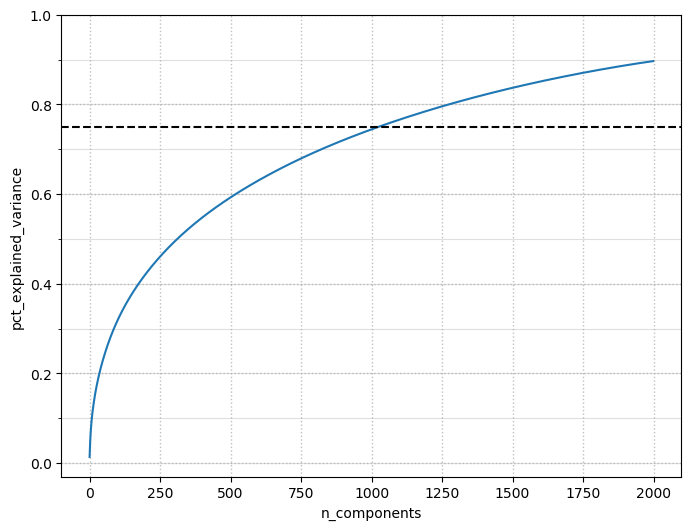

In [66]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(p.shape[1]), np.cumsum(svd.explained_variance_))
ax.axhline(0.75, ls='--', c='k')
ax.grid(linestyle=':', linewidth=1)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_yticks(np.arange(0, 1.2, 0.2), minor=False)
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.8)
ax.set_xlabel('n_components')
ax.set_ylabel('pct_explained_variance');

In [ ]:
# pickle TF-IDF NMF results
pickle_file = 'APP_tfidf_svd_results.pickle'
data = {'tfidf_vectorizer': tfidf_vectorizer, 
        'tfidf': tfidf,
        'svd': svd}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

### Check Clustering Metrics

In [ ]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
inertias = []
silhouettes = []
n_clusters = np.arange(5, 55, 5)
for n in tnrange(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[n], init="k-means++", random_state=129)
    kmeans.fit(reduced)
    
    inertias.append(kmeans.inertia_)
    
    # only a sample was used to calculate silhouette score because of memory errors
    labels = kmeans.labels_
    silhouettes.append(silhouette_score(reduced, labels, metric='euclidean', sample_size=10000))

In [ ]:
# plot the inertia scores and look for the kink in the curve
plt.style.use('default')
plt.plot(n_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

In [ ]:
# plot the silhouettte scores
plt.plot(n_clusters, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score');

In [ ]:
seed = 129
kmeans = KMeans(n_clusters=20, init="k-means++", random_state=seed)
kmeans.fit(reduced)
labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))

silhouette = silhouette_score(reduced, 
                              labels, 
                              metric='euclidean', 
                              sample_size=10000, 
                              random_state=seed)
print("Silhouette score: {}".format(silhouette))

### TSNE Dimension Reduction and Visualization

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=seed)
tsne_reduced = tsne.fit_transform(reduced)

In [ ]:
df_tsne_reduced = pd.DataFrame(tsne_reduced, columns=["tsne_x", "tsne_y"])
df_tsne_reduced.shape

In [ ]:
df_tsne_reduced['Cluster'] = labels
df_tsne_reduced.info()

In [ ]:
groups = df_tsne_reduced.groupby('Cluster')

In [ ]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)
cmap = colors.iloc[:, 1]

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))
cidx = 0
for name, group in groups:
    ax.plot(group.tsne_x, group.tsne_y, marker='o', linestyle='', ms=2, alpha=0.2, label=name, color=cmap[cidx])
    cidx += 1
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
label_strings = ['Topic #%d' % x for x in set(labels)]

# leg = ax.legend(loc='upper right')
leg = ax.legend(label_strings, loc=9, bbox_to_anchor=(1.1, 1), 
                labelspacing=1, borderpad=1)
leg.get_frame().set_facecolor('k')
leg.get_frame().set_color('k')
for text in leg.get_texts():
    text.set_color('w')
    text.set_fontsize(11)
    text.set_fontweight('bold')

for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(10)